# **Elaborato per il corso di Analytics in Economics and Business, MD2SL 2024**
## *Dario Comanducci*

# Introduzione

L’elaborato qui presentato è basato su una pubblicazione di N. Nunn, *"The Long-term Effects of Africa’s Slave Trades"* (The Quarterly Journal of Economics, 123(1):139–176, 2008), dove viene analizzato l’impatto a lungo termine che la tratta degli schiavi ha avuto sull’economia odierna degli Stati africani.

Nell'ottica dell'analisi causale, la tratta degli schiavi costituisce il trattamento $d$ mentre la risposta $y$ è caratterizzata dal PIL pro capite degli Stati (sia $y$ che $d$ su base logaritmica). A differenza di Nunn che ha condotto l'analisi attraverso delle variabili strumentali (ossia le distanze tra ciascun Paese africano e le principali località in cui gli schiavi venivano richiesti) seguendo il procedimento classico tramite Two-Stage LS, si vuole qui adottare sullo stesso dataset l'approccio Double ML proposto da
V. Chernozhukov et al. in *"Double/debiased machine learning for treatment and structural parameters"* (The Econometrics Journal, 21(1):C1–C68, 01 2018).

Il codice è stato sviluppato su Python 3.9.19

# Analisi dei dati
Il dataset impiegato da Nunn è disponibile in https://nathannunn.sites.olt.ubc.ca/files/2022/02/DATA-22The-Long-Term-Effects-of-Africas-Slave-Trades22-slave_trade_qje_replication_dataset.zip

Riportiamo qui brevemente la descrizione contenuta nel dataset delle sue variabili, raggruppate per tipologia:
- variabile di risposta $y$
    - *ln_maddison_pcgdp2000*, Log per capita GDP
- trattamento $d$
    - *ln_export_area*, Log total slave exports normalized by land area
- passato coloniale (ultimi colonizzatori di ciascun Paese)
    - *colony0*, not colonized
    - *colony1*, Britan 
    - *colony2*, France 
    - *colony3*, Portugal
    - *colony4*, Belgium
    - *colony5*, Spain
    - *colony6*, UN
    - *colony7*, Italy
- geografia/clima
    - *abs_latitude*, Absolute latitude
    - *longitude*, Longitude
    - *rain_min*, Min of monthly average rainfall (mm)
    - *humid_max*, Max of monthly afternoon avg humidity (%)
    - *low_temp*, Min of avg monthly low temp (C)
    - *ln_coastline_area*, Log (coastline/land_area)
- religione
    - *islam*, Percent Islamic
- base legislativa
    - *legor_fr*, French legal origin indicator 
    - *legor_uk*, British legal origin indicator
- regioni africane
    - *island_dum*, Indicator variable for small islands
    - *region_n*, North idicator
    - *region_s*, South idicator
    - *region_w*, West idicator
    - *region_e*, East indicator 
    - *region_c*, Central indicator
- produzione mineraria
    - *ln_avg_gold_pop*, Log gold production per capita
    - *ln_avg_oil_pop*, Log oil production per capita
    - *ln_avg_all_diamonds_pop*, Log diamond production per capita
- variabili strumentali $z_i$ ($i=1 \dots 4$)
    - *atlantic_distance_minimum*, Minimum Atlantic distance (000s of kms)
    - *indian_distance_minimum*, Minimum Indian distance (000s of kms)
    - *saharan_distance_minimum*, Minimum Saharan distance (000s of kms)
    - *red_sea_distance_minimum*, Minimum Red Sea distance (000s of kms)
- variabili "extra" (variabili di sostegno nella validazione di alcune congetture)
    - *ln_export_pop*, Log total slave exports normalized by historic population
    - *ln_pop_dens_1400*, Log population density in 1400
    - *ethnic_fractionalization*, Ethnic fractionalization
    - *state_dev*, State development
    - *land_area*, Land area in millions of square kms

Si rimanda al notebook DataMaps.ipynb per una visualizzazione su mappe delle variabili presenti nel dataset. 

Le variabili strumentali (IV) sono quattro in quanto tali sono state le tratte di schiavi subite dall'Africa (tratta transatlantica, tratta indiana, tratta transahariana, tratta del Mar Rosso), e sono date dalla distanza di ciascun Paese rispetto alle destinazioni principali nella domanda degli schiavi. Poiché ci sono evidenze che la posizione dell’offerta non è stata influenzata dalla localizzazione della domanda, tali IV costituiscono degli strumenti validi.

All'interno del dataset si distinguono variabili continue e discrete:
- sono continue
    - *ln_maddison_pcgdp2000*
    - *ln_export_area*
    - *abs_latitude*, *longitude*, *rain_min*, *humid_max*, *low_temp*, *ln_coastline_area*
    - *islam*
    - *ln_avg_gold_pop*, *ln_avg_oil_pop*, *ln_avg_all_diamonds_pop*
    - *atlantic_distance_minimum*, *indian_distance_minimum*, *saharan_distance_minimum*, *red_sea_distance_minimum*
- sono discrete (binarie)
    - *colony0* . . . *colony7*
    - *legor_fr* e *legor_uk*
    - *island_dum*, *region_n*, *region_s*, *region_w*, *region_e*, *region_c*

Analizziamo di seguito come i vari dati si relazionano tra di loro (per semplicità omettiamo analisi incrociate tra variabili di tipo continuo e discreto).

## Variabili continue
### Distribuzioni campionarie

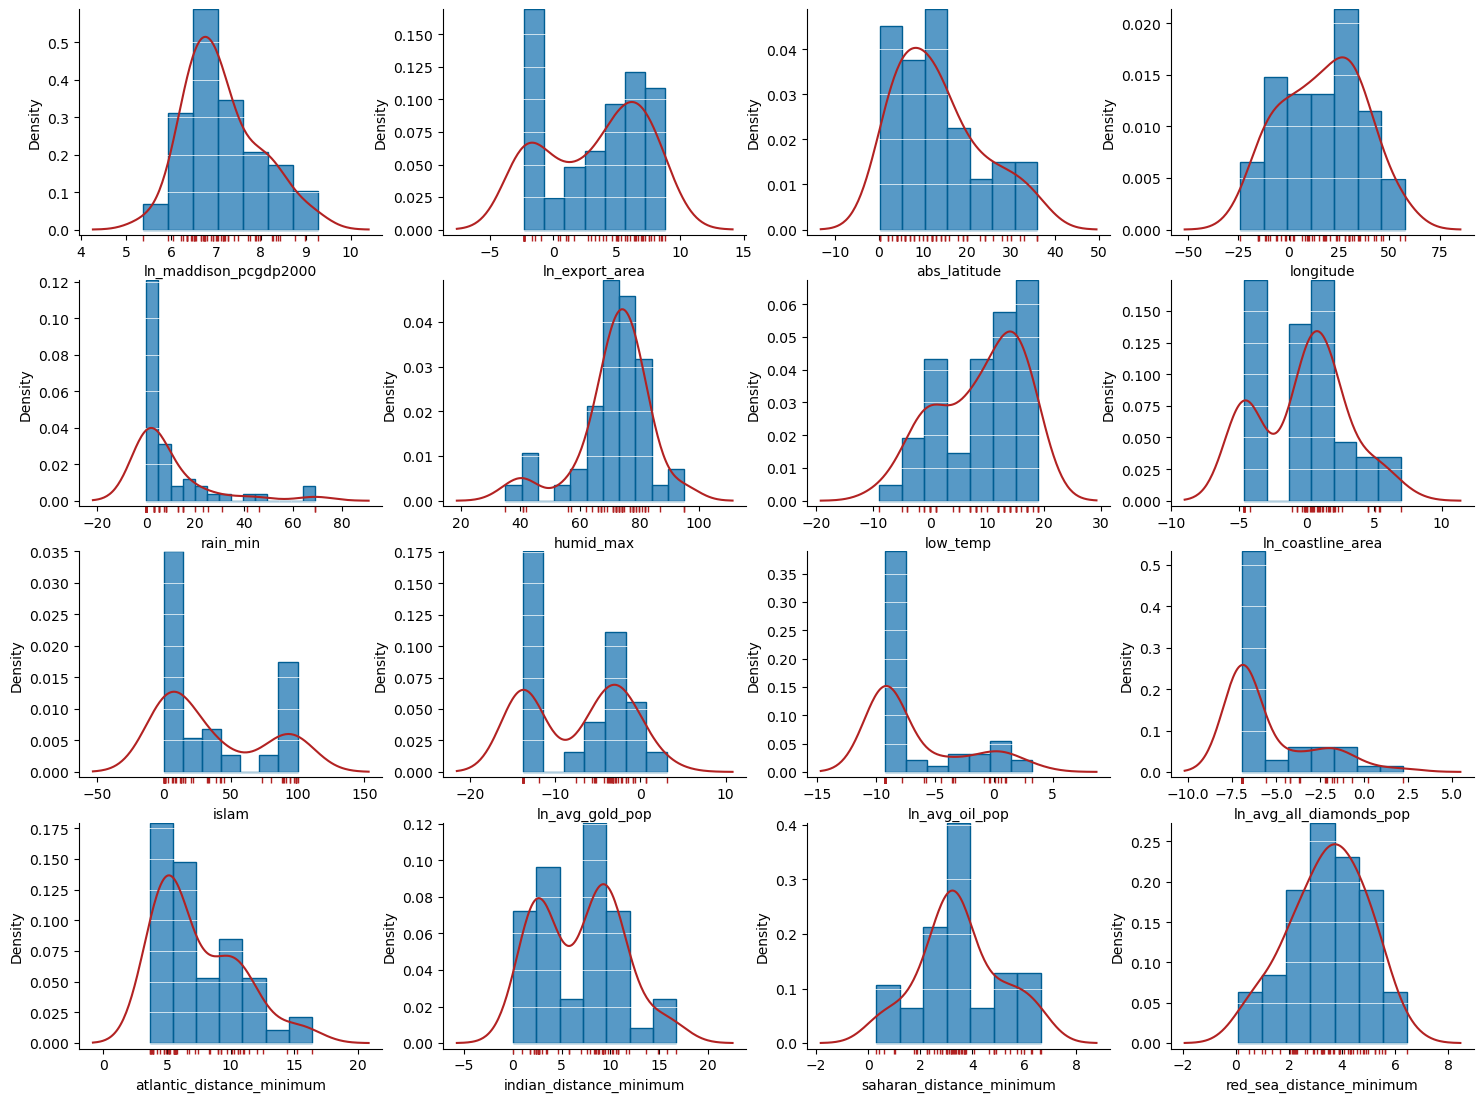

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def subplotHist(ax, df, col):
    xdf = df[col];
    sns.histplot(xdf, stat='density', ax=ax, edgecolor='#005e93')
    sns.rugplot(xdf, ax=ax, color='firebrick', height=-0.025, clip_on=False)
    sns.kdeplot(xdf, ax=ax, color='firebrick')
    _ = ax.grid(axis='y', color='white', linewidth=0.5)
    _ = ax.spines['top'].set_visible(False)
    _ = ax.spines['right'].set_visible(False)
    _ = ax.set_xlabel(col);

#------------------------------------------------------------------------------------------------
fname = 'slave_trade_QJE.dta'
df = pd.read_stata(fname)

cvar = ['ln_maddison_pcgdp2000', 'ln_export_area', 'abs_latitude', 'longitude',
        'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area',
        'islam', 'ln_avg_gold_pop', 'ln_avg_oil_pop', 'ln_avg_all_diamonds_pop',
        'atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum']

fig, axes = plt.subplots(4,4, figsize=(18, 13.5))
subplotHist(axes[0,0], df, cvar[ 0]) #ln_maddison_pcgdp2000
subplotHist(axes[0,1], df, cvar[ 1]) #ln_export_area
subplotHist(axes[0,2], df, cvar[ 2]) #abs_latitude
subplotHist(axes[0,3], df, cvar[ 3]) #longitude
subplotHist(axes[1,0], df, cvar[ 4]) #rain_min
subplotHist(axes[1,1], df, cvar[ 5]) #humid_max
subplotHist(axes[1,2], df, cvar[ 6]) #low_temp
subplotHist(axes[1,3], df, cvar[ 7]) #ln_coastline_area
subplotHist(axes[2,0], df, cvar[ 8]) #islam
subplotHist(axes[2,1], df, cvar[ 9]) #ln_avg_gold_pop
subplotHist(axes[2,2], df, cvar[10]) #ln_avg_oil_pop
subplotHist(axes[2,3], df, cvar[11]) #ln_avg_all_diamonds_pop
subplotHist(axes[3,0], df, cvar[12]) #atlantic_distance_minimum
subplotHist(axes[3,1], df, cvar[13]) #indian_distance_minimum
subplotHist(axes[3,2], df, cvar[14]) #saharan_distance_minimum
subplotHist(axes[3,3], df, cvar[15]) #red_sea_distance_minimum

plt.show()

Dati i pochi esempi (gli Stati africani in esame sono solo 52), gli istogrammi non forniscono molte indicazioni sulle distribuzioni delle variabili considerate se non che alcune variabili sembrano mostrare una distribuzione bimodale come
- il trattamento stesso *ln_export_area*, con alcuni Paesi che hanno subito poco la tratta degli schiavi;
- ciascuna risorsa mineraria, con molti paesi privi della risorsa in questione (tuttavia, dalle mappe del notebook DataMaps si nota anche che laddove manca una risorsa mineraria, lo stesso Paese dispone di almeno una delle altre due);
- la religione islamica, confermata dalla mappa corrispondente in DataMaps;
- la vicinanza all’oceano, per come è stata definita *ln_coastline_area* in quanto i paesi dell’Africa centrale sono privi di linea costiera;
- la variabile strumentale *indian_distance_minimum*, forse per la dislocazione dei due soli mercati di destinazione nella tratta indiana (Mauritius e Oman).

### Correlazioni tra le variabili continue

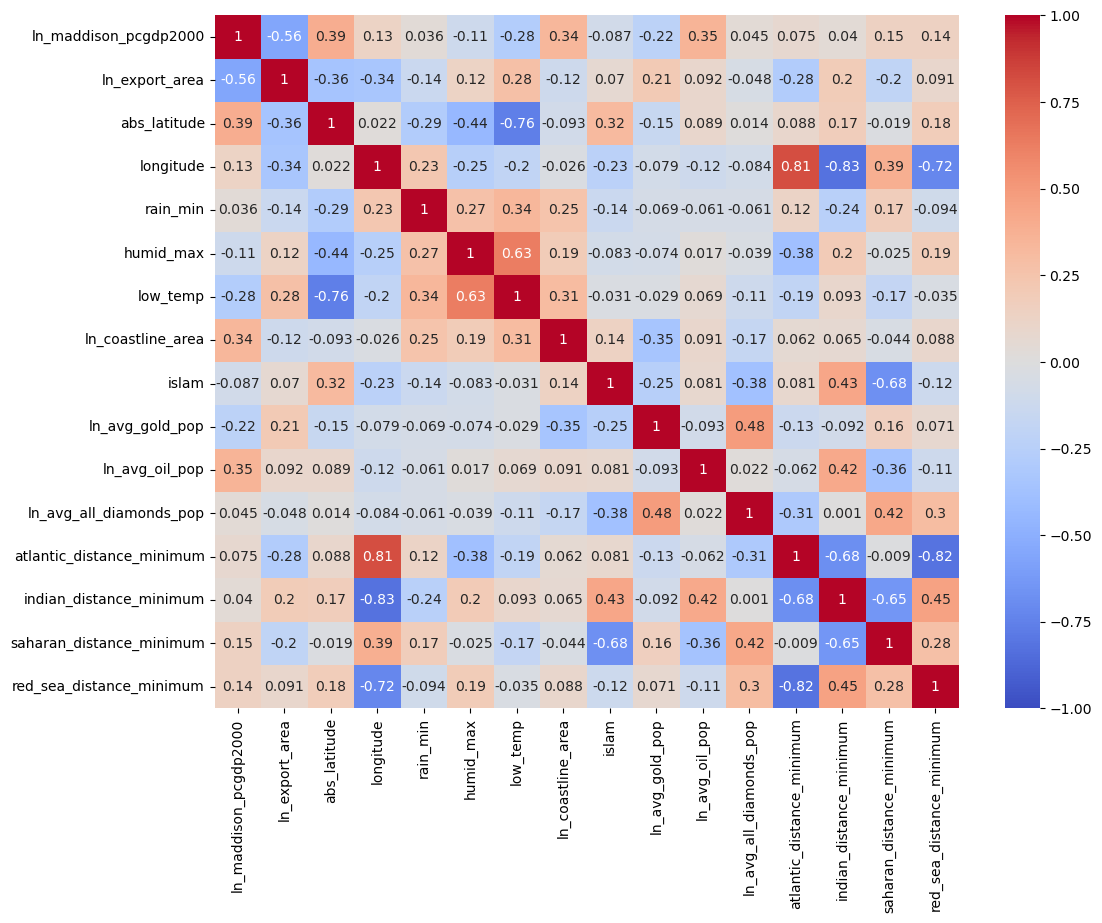

In [2]:
cdf = df[cvar]
corr = cdf.corr().round(3)
fig, ax = plt.subplots(figsize=(12, 9))
_ = sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
plt.show()

L'analisi di correlazione mostra che
- esiste una forte correlazione tra tre variabili strumentali (positiva per *atlantic_distance_minimum*, negativa per *indian_distance_minimum* e *red_sea_distance_minimum*) e *longitude*;
- la tratta transahariana (*saharan_distance_minimum*) è invece correlata con la percentuale di fede islamica nei vari Stati (*islam*);
- le distanze della tratta transatlantica sono negativamente correlate con le distanze della tratta indiana e quella del mar Rosso;
- le distanze della tratta indiana sono negativamente correlate anche a quelle della tratta transahariana;
- la temperatura minima (*low_temp*) è negativamente correlata con la distanza dall’equatore (*abs_latitude*) e positivamente con l’umidità (*humid_max*).

### Grafici di dispersione per le variabili continue più correlate

<Figure size 1200x1200 with 0 Axes>

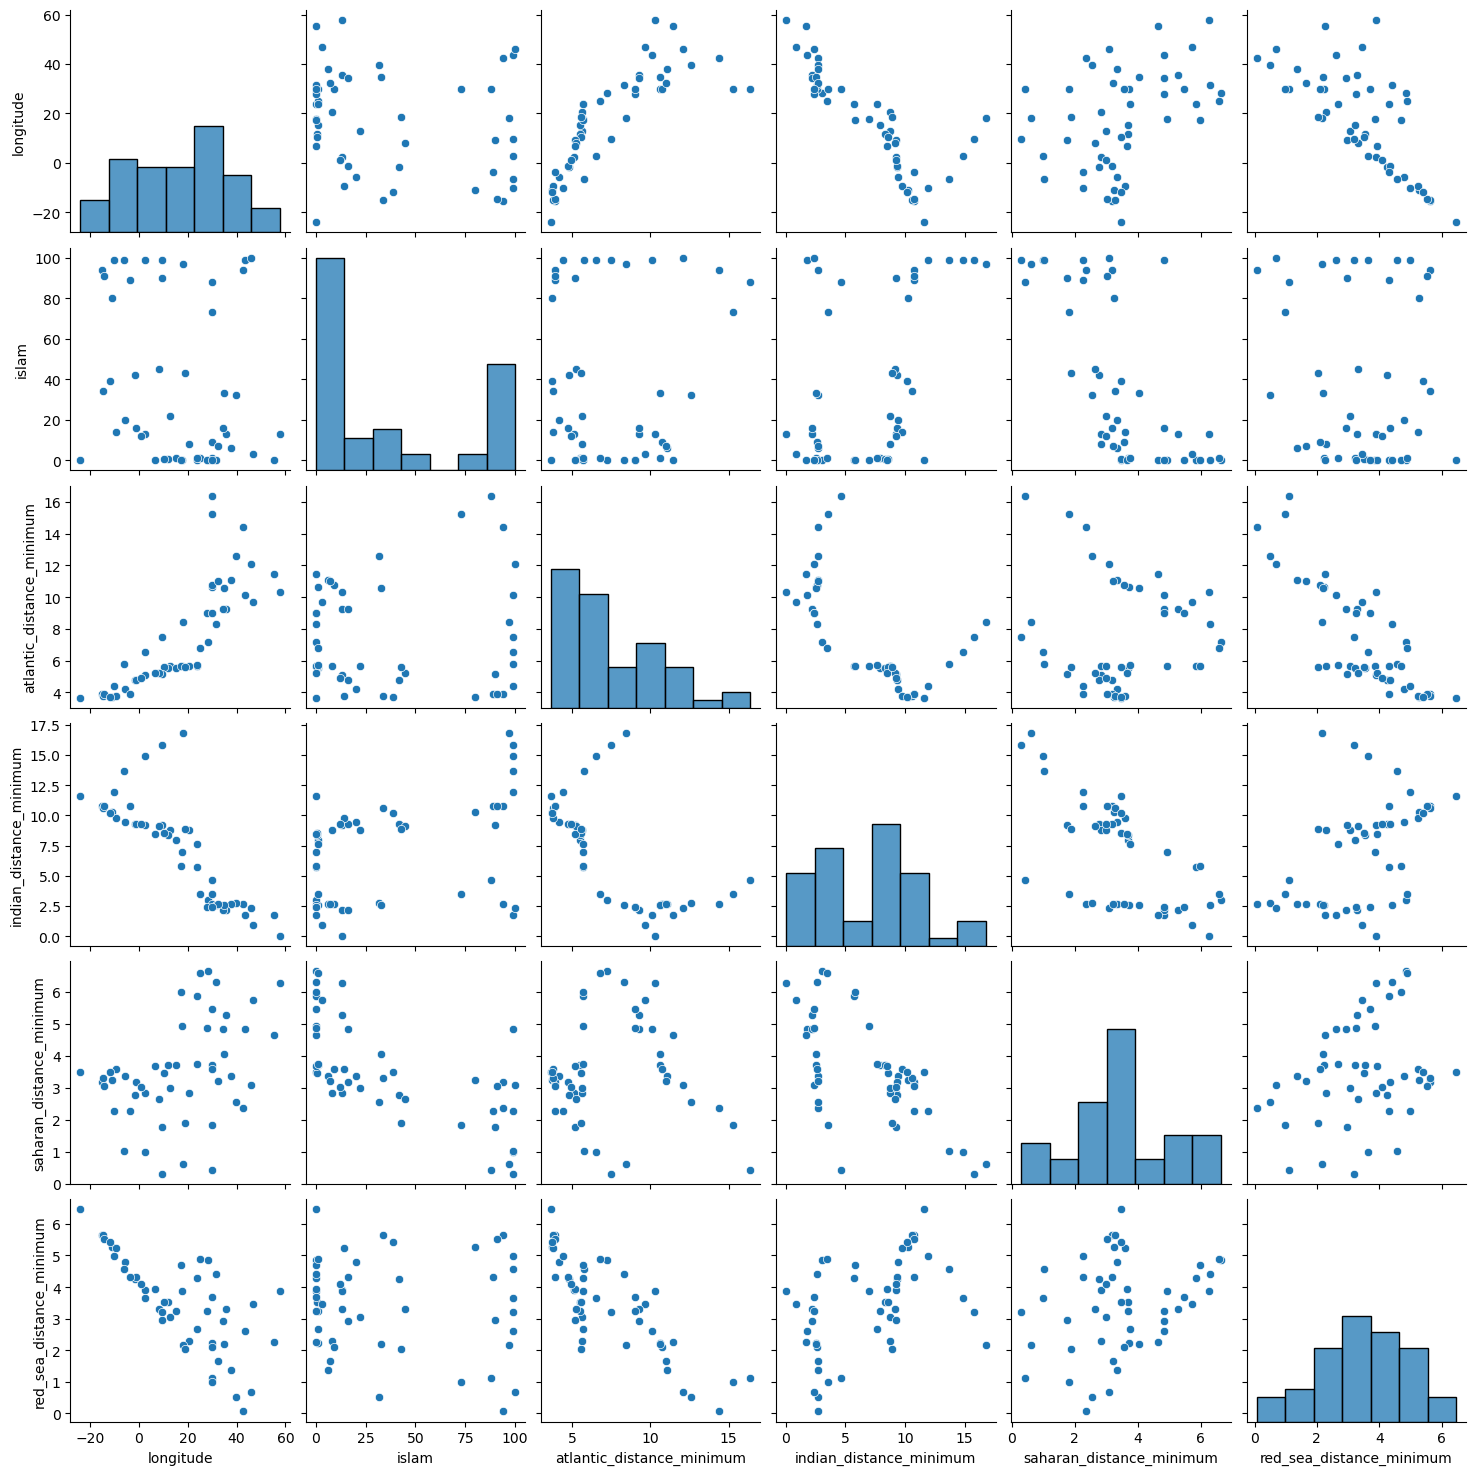

In [3]:
corrIdList = [3, 8, 12, 13, 14, 15]
cHighCorr = [cvar[i] for i in corrIdList]
_ = plt.figure(figsize=(12, 12))
_ = sns.pairplot(df[cHighCorr], diag_kind='hist')
plt.show()

## Variabili discrete/binarie
Le variabili discrete sono tutte di tipo binario; ciò nonostante possono essere raggruppate in tre grandi tipologie:
- ex-colonie,
- base legislativa
- aree geografiche
  
### Ex-colonie: numero di occorrenze

In [4]:
print('0 colonizers: ' + str(sum(df.colony0)))
print('GB colonies: '  + str(sum(df.colony1)))
print('FR colonies: '  + str(sum(df.colony2)))
print('PT colonies: '  + str(sum(df.colony3)))
print('BE colonies: '  + str(sum(df.colony4)))
print('ES colonies: '  + str(sum(df.colony5)))
print('UN colonies: '  + str(sum(df.colony6)))
print('IT colonies: '  + str(sum(df.colony7)))

0 colonizers: 2.0
GB colonies: 18.0
FR colonies: 21.0
PT colonies: 5.0
BE colonies: 3.0
ES colonies: 1.0
UN colonies: 1.0
IT colonies: 1.0


### Base legislativa: occorrenze

In [5]:
print('Legal orig FR: ' + str(sum(df.legor_fr)))
print('Legal orig UK: ' + str(sum(df.legor_uk)))

Legal orig FR: 34.0
Legal orig UK: 18.0


### Aree geografiche: occorrenze

In [6]:
print('Small Islands: ' + str(sum(df.island_dum)))
print('North Africa: ' + str(sum(df.region_n)))
print('South Africa: ' + str(sum(df.region_s)))
print('West Africa: ' + str(sum(df.region_w)))
print('East Africa: ' + str(sum(df.region_e)))
print('Central Africa: ' + str(sum(df.region_c)))

Small Islands: 5.0
North Africa: 5.0
South Africa: 9.0
West Africa: 16.0
East Africa: 13.0
Central Africa: 9.0


### Tabelle di contingenza per le variabili discrete
Avendo raggruppato le variabili discrete in base alla loro tipologia, le matrici di contingenza che seguono riguardano pertanto 
- Ex-colonie vs. Base legislativa
- Ex-colonie vs. Aree geografiche
- Base legislativa vs. Aree geografiche

Ex-colonie vs Base legislativa


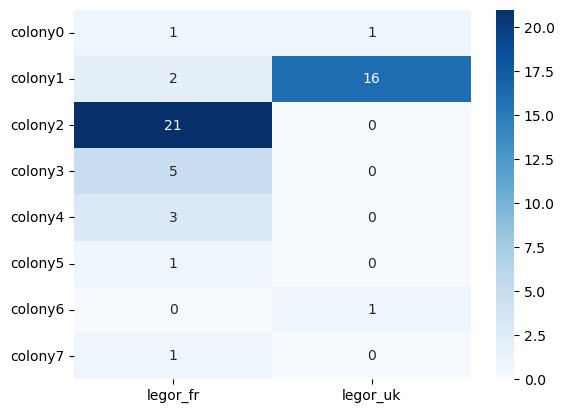

Ex-colonie vs Aree geografiche


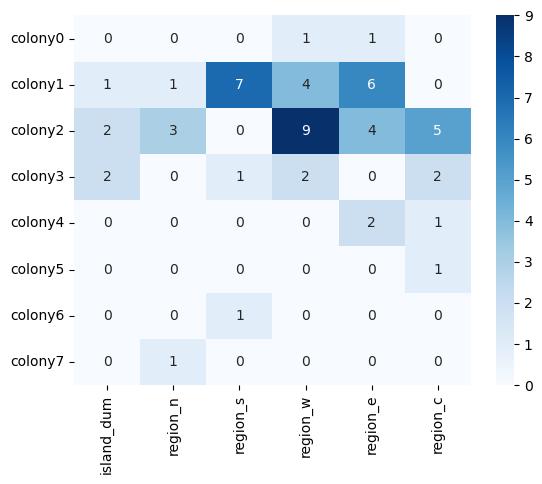

Base legislativa vs Aree geografiche


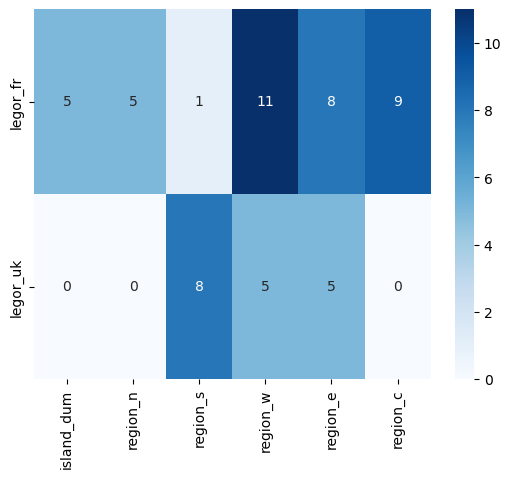

In [7]:
colvar = ['colony0', 'colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6',  'colony7']
legvar = ['legor_fr', 'legor_uk']
regvar = ['island_dum', 'region_n', 'region_s', 'region_w', 'region_e', 'region_c']

contColLeg = np.zeros(shape=(len(colvar), len(legvar)))
contColReg = np.zeros(shape=(len(colvar), len(regvar)))
contLegReg = np.zeros(shape=(len(legvar), len(regvar)))
for idx, row in df.iterrows():
    for c in range(len(colvar)):
        if row[colvar[c]] == 1:
            for l in range(len(legvar)):
                if row[legvar[l]] == 1:
                    contColLeg[c,l] += 1
            for r in range(len(regvar)):
                if row[regvar[r]] == 1:
                    contColReg[c,r] += 1
    for l in range(len(legvar)):
        if row[legvar[l]] == 1: 
            for r in range(len(regvar)):
                if row[regvar[r]] == 1:
                    contLegReg[l,r] += 1

print('Ex-colonie vs Base legislativa')
contColLeg_df = pd.DataFrame(contColLeg, index=colvar, columns=legvar)
fig, ax = plt.subplots()
_ = sns.heatmap(contColLeg_df, annot=True, cmap='Blues', vmin=0, ax=ax)
plt.show()

print('Ex-colonie vs Aree geografiche')
contColReg_df = pd.DataFrame(contColReg, index=colvar, columns=regvar)
fig, ax = plt.subplots()
_ = sns.heatmap(contColReg_df, annot=True, cmap='Blues', vmin=0, ax=ax)
plt.show()

print('Base legislativa vs Aree geografiche')
contLegReg_df = pd.DataFrame(contLegReg, index=legvar, columns=regvar)
fig, ax = plt.subplots()
_ = sns.heatmap(contLegReg_df, annot=True, cmap='Blues', vmin=0, ax=ax)
plt.show()

Come in effetti si poteva dedurre osservando le mappe nel notebook DataMaps relative al passato coloniale e alla base legislativa, da tali tabelle risulta che l’Africa ha subito prevalentemente l’influenza francese e quella britannica: i francesi maggiormente nei Paesi nord-occidentali e centrali dell’Africa; gli inglesi nel Sud e nell’Est del continente africano.

# Risultati sperimentali
## Replica dei risultati riportati nell’articolo
Prima di applicare l'approccio Double ML, si verifica che i dati nel dataset confermino i risultati dell'artcolo.
### Stime OLS senza IV
Il lavoro di Nunn ha prima valutato il coefficiente realtivo al trattamento $d$ applicando progressivamente vari controlli al modello di regressione lineare, senza l'impiego di variabili strumentali (IV).

Di seguito vengono riprodotti le stesse analisi impiegando tutti i Paesi africani: Nunn ha eseguito delle regressioni anche escludendo i Paesi del Nord Africa e quelli composti da piccole isole in quanto potenziali outliers, ma qui per semplicità ci limiteremo al caso completo (in ogni caso, i risultati di Nunn non cambiavano molto nei due casi).  I valori trovati concordano con quelli nell'articolo (colonne (1), (2), (4) e (5) di Table III).

#### Solo controlli di colonizzazione

In [8]:
import statsmodels.api as sm
from ISLP.models import summarize

y = df['ln_maddison_pcgdp2000']
d = df['ln_export_area']

ctrl1 = ['colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7']
Xols1 = sm.add_constant(pd.concat([d, df[ctrl1]], axis=1))
ols1 = sm.OLS(y, Xols1)
resOls1 = ols1.fit()
print(summarize(resOls1))

                  coef  std err       t  P>|t|
const           7.2153    0.467  15.464  0.000
ln_export_area -0.1119    0.024  -4.703  0.000
colony1         0.3621    0.475   0.763  0.450
colony2         0.3135    0.470   0.667  0.508
colony3         0.2108    0.531   0.397  0.693
colony4        -0.8893    0.585  -1.519  0.136
colony5         1.6561    0.790   2.096  0.042
colony6         0.8621    0.793   1.088  0.283
colony7         0.7156    0.780   0.917  0.364


#### Aggiunta dei controlli geo-climatici

In [9]:
ctrl2 = ctrl1 + ['abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']
Xols2 = sm.add_constant(pd.concat([d, df[ctrl2]], axis=1))
ols2 = sm.OLS(y, Xols2)
resOls2 = ols2.fit()
print(summarize(resOls2))

                     coef  std err      t  P>|t|
const              5.9441    1.108  5.364  0.000
ln_export_area    -0.0762    0.029 -2.620  0.013
colony1            0.8392    0.552  1.521  0.137
colony2            0.7651    0.560  1.367  0.180
colony3            0.4489    0.592  0.758  0.453
colony4            0.0823    0.770  0.107  0.915
colony5            2.1373    0.839  2.547  0.015
colony6            1.3410    0.928  1.444  0.157
colony7            0.7518    0.833  0.903  0.372
abs_latitude       0.0158    0.017  0.949  0.349
longitude          0.0005    0.005  0.091  0.928
rain_min          -0.0006    0.007 -0.093  0.926
humid_max          0.0094    0.012  0.801  0.428
low_temp          -0.0189    0.028 -0.665  0.510
ln_coastline_area  0.0847    0.039  2.185  0.035


#### Aggiunta dei fattori caratterizzanti Nord-Africa e piccole isole

In [10]:
ctrl3 = ctrl2 + ['islam', 'legor_fr', 'island_dum', 'region_n']
Xols3 = sm.add_constant(pd.concat([d, df[ctrl3]], axis=1))
ols3 = sm.OLS(y, Xols3)
resOls3 = ols3.fit()
print(summarize(resOls3))

                     coef  std err      t  P>|t|
const              5.7431    1.094  5.252  0.000
ln_export_area    -0.0854    0.035 -2.447  0.020
colony1            1.2496    0.579  2.160  0.038
colony2            0.5444    0.541  1.006  0.322
colony3           -0.0247    0.585 -0.042  0.967
colony4           -0.4588    0.727 -0.631  0.532
colony5            1.3864    0.819  1.692  0.100
colony6            1.5813    0.956  1.654  0.108
colony7            0.6273    0.806  0.778  0.442
abs_latitude       0.0194    0.018  1.105  0.277
longitude         -0.0038    0.006 -0.684  0.499
rain_min           0.0001    0.007  0.019  0.985
humid_max          0.0090    0.012  0.781  0.440
low_temp          -0.0049    0.027 -0.179  0.859
ln_coastline_area  0.0954    0.042  2.252  0.031
islam             -0.0084    0.003 -2.935  0.006
legor_fr           0.7551    0.503  1.500  0.143
island_dum        -0.3983    0.529 -0.753  0.457
region_n           0.3818    0.484  0.789  0.436


#### Aggiunta della produzione mineraria

In [11]:
ctrl4 = ctrl3 + ['ln_avg_gold_pop', 'ln_avg_oil_pop', 'ln_avg_all_diamonds_pop']
Xols4 = sm.add_constant(pd.concat([d, df[ctrl4]], axis=1))
ols4 = sm.OLS(y, Xols4)
resOls4 = ols4.fit()
print(summarize(resOls4))

                           coef  std err      t  P>|t|
const                    6.0241    1.055  5.710  0.000
ln_export_area          -0.1032    0.034 -3.049  0.005
colony1                  1.0750    0.551  1.951  0.060
colony2                  0.3683    0.513  0.718  0.478
colony3                 -0.1035    0.560 -0.185  0.855
colony4                 -0.5897    0.678 -0.870  0.391
colony5                  0.7023    0.843  0.833  0.411
colony6                  1.6933    0.901  1.879  0.070
colony7                  0.0429    0.783  0.055  0.957
abs_latitude             0.0228    0.017  1.381  0.177
longitude               -0.0039    0.005 -0.735  0.468
rain_min                -0.0010    0.006 -0.152  0.880
humid_max                0.0148    0.011  1.344  0.189
low_temp                -0.0151    0.026 -0.578  0.567
ln_coastline_area        0.0825    0.040  2.078  0.046
islam                   -0.0059    0.003 -1.943  0.061
legor_fr                 0.6427    0.470  1.368  0.182
island_dum

### Introduzione delle variabili strumentali
Ricordiamo che le variabili strumentali sono date dalla distanza di ciascun Paese rispetto alle destinazioni principali nella domanda di schiavi, in relazione alle quattro tratte subite dall'Africa: *atlantic_distance_minimum*, *indian_distance_minimum*, *saharan_distance_minimum* e *red_sea_distance_minimum*

Nel lavoro di Nunn sono stati analizzati i seguenti casi:
- impiego solo delle IV, senza alcun controllo addizionale;
- inserimento delle variabili coloniali tra i controlli;
- aggiunta dei controlli geo-climatici.

In tutti i casi Nunn ha fatto ricorso alla tecnica Two-Stage Least Square: i valori trovati per $\alpha$ concordano con quelli nell'articolo (colonne (1) (2) e (3) di Table IV).
#### Solo IV

In [12]:
iv = ['atlantic_distance_minimum', 'indian_distance_minimum', 'saharan_distance_minimum', 'red_sea_distance_minimum']

# stage I
print('Stage I')
XivI1 = sm.add_constant(df[iv])
stageI1 = sm.OLS(d, XivI1)
resStageI1 = stageI1.fit()
print(summarize(resStageI1))

# stage II
print('\nStage II')
XivII1 = sm.add_constant(d)
XivII1.ln_export_area = resStageI1.predict()
stageII1 = sm.OLS(y, XivII1)
resStageII1 = stageII1.fit()
print(summarize(resStageII1))

Stage I
                              coef  std err      t  P>|t|
const                      29.1097    6.959  4.183  0.000
atlantic_distance_minimum  -1.3140    0.357 -3.683  0.001
indian_distance_minimum    -1.0954    0.380 -2.884  0.006
saharan_distance_minimum   -2.4349    0.823 -2.958  0.005
red_sea_distance_minimum   -0.0019    0.710 -0.003  0.998

Stage II
                  coef  std err       t  P>|t|
const           7.8114    0.187  41.879    0.0
ln_export_area -0.2079    0.049  -4.285    0.0


#### Aggiunta dei controlli coloniali

In [13]:
# stage I
print('Stage I')
XivI2 = sm.add_constant(pd.concat([df[iv], df[ctrl1]], axis=1))
stageI2 = sm.OLS(d, XivI2)
resStageI2 = stageI2.fit()
print(summarize(resStageI2))

# stage II
print('\nStage II')
XivII2 = sm.add_constant(pd.concat([d, df[ctrl1]], axis=1))
XivII2.ln_export_area = resStageI2.predict()
stageII2 = sm.OLS(y, XivII2)
resStageII2 = stageII2.fit()
print(summarize(resStageII2))


Stage I
                              coef  std err      t  P>|t|
const                      38.3928    8.853  4.337  0.000
atlantic_distance_minimum  -1.7414    0.425 -4.102  0.000
indian_distance_minimum    -1.4262    0.531 -2.686  0.010
saharan_distance_minimum   -3.0011    1.049 -2.860  0.007
red_sea_distance_minimum   -0.1521    0.813 -0.187  0.853
colony1                    -0.3592    2.605 -0.138  0.891
colony2                    -2.0516    2.564 -0.800  0.428
colony3                    -0.6215    2.959 -0.210  0.835
colony4                    -3.6295    3.141 -1.156  0.255
colony5                    -6.5378    4.251 -1.538  0.132
colony6                    -3.0404    4.454 -0.683  0.499
colony7                     3.9700    5.582  0.711  0.481

Stage II
                  coef  std err       t  P>|t|
const           7.7160    0.490  15.739  0.000
ln_export_area -0.2014    0.040  -5.040  0.000
colony1         0.1513    0.469   0.322  0.749
colony2         0.1437    0.463   0.310 

#### Aggiunta dei controlli geo-climatici

In [14]:
# stage I
print('Stage I')
XivI3 = sm.add_constant(pd.concat([df[iv], df[ctrl2]], axis=1))
stageI3 = sm.OLS(d, XivI3)
resStageI3 = stageI3.fit()
print(summarize(resStageI3))

# stage II
print('\nStage II')
XivII3 = sm.add_constant(pd.concat([d, df[ctrl2]], axis=1))
XivII3.ln_export_area = resStageI3.predict()
stageII3 = sm.OLS(y, XivII3)
resStageII3 = stageII3.fit()
print(summarize(resStageII3))

Stage I
                              coef  std err      t  P>|t|
const                      39.1188   15.857  2.467  0.019
atlantic_distance_minimum  -1.3163    0.761 -1.730  0.093
indian_distance_minimum    -1.0810    0.697 -1.550  0.130
saharan_distance_minimum   -1.1393    1.595 -0.714  0.480
red_sea_distance_minimum   -1.2214    1.820 -0.671  0.507
colony1                    -2.4563    3.436 -0.715  0.480
colony2                    -3.3958    3.461 -0.981  0.334
colony3                    -3.8935    3.669 -1.061  0.296
colony4                    -5.8491    4.490 -1.303  0.201
colony5                    -8.0328    4.667 -1.721  0.094
colony6                    -8.7829    6.012 -1.461  0.153
colony7                     3.1688    6.361  0.498  0.622
abs_latitude                0.0113    0.124  0.091  0.928
longitude                  -0.1088    0.131 -0.827  0.414
rain_min                   -0.0437    0.039 -1.131  0.266
humid_max                  -0.0930    0.080 -1.156  0.256
low_te

## Stime tramite Double ML
Dalle varie combinazioni dei controlli analizzati nell'articolo, è stato preso come caso di studio sull’approccio Double ML quello che impiega le variabili coloniali e geoclimatiche, ossia il caso con maggior numero di controlli tra quelli testati da Nunn con e senza variabili strumentali.


Come metodi di Machine Learning verranno presi in esame dei modelli ad albero: Bagging e Random Forest. Entrambi i modelli si basano sull'addestramento di un ensemble di alberi su varianti del dataset soggette a boostrap, con la differenza che le Random Forest impiegano ad ogni split un sottoinsieme casuale delle variabili nel dataset.

Dato il piccolo numero di osservazioni (gli Stati africani sono poco più di 50), si è ritienuto che il boostrap sia rilevante per avere dei buoni modelli di predizione.

I modelli di ML verranno valutati non solo per predire la risposta $y$ ed il trattamento $d$, ma anche per modellare le variabili strumentali.

### Iper-parametri ottimali
Per fissare i parametri ottimali si è fatto ricorso alla tecnica di cross-validazione Leave-One-Out, in cui il dataset è partizionato in tanti insiemi quanti sono le osservazioni che lo compongono: ad ogni giro di cross-validazione tutto il dataset ad eccezione di un elemento viene impiegato nell'addestramento del modello, e cross-validato sull'osservazione esclusa. La ragione di ciò è sempre il numero limitato di elementi che compongono il dataset.

Riprendendo lo studio fatto in [Bach et al. 2024] sulla selezione degli iper-parametri in ambito Double ML (si veda tra i riferimenti bibliografici, al termine) gli iper-parametri sono stati determinati sull’intero dataset (lo studio di Bach sconsiglia ad esempio di dividere il dataset in due parti, di cui una da impiegare per la cross-validazione degli iper-parametri, specialmente con dataset piccoli). 

**ATTENZIONE: l'esecuzione del seguente blocco di codice è molto lunga, arrivando anche a 4h.**

Riportiamo per comodità l'output che ne deriva
- Bagging (BG)
    - BG y: {'min_samples_leaf': 7, 'n_estimators': 100}
    - BG d: {'min_samples_leaf': 3, 'n_estimators': 5000}
    - BG iv1: {'min_samples_leaf': 5, 'n_estimators': 50}
    - BG iv2: {'min_samples_leaf': 3, 'n_estimators': 500}
    - BG iv3: {'min_samples_leaf': 3, 'n_estimators': 10}
    - BG iv4: {'min_samples_leaf': 3, 'n_estimators': 50}
- Random Forest (RF)
    - RF y: {'max_features': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
    - RF d: {'max_features': 12, 'min_samples_leaf': 3, 'n_estimators': 1000}
    - RF iv1: {'max_features': 12, 'min_samples_leaf': 5, 'n_estimators': 50}
    - RF iv2: {'max_features': 10, 'min_samples_leaf': 3, 'n_estimators': 10}
    - RF iv3: {'max_features': 12, 'min_samples_leaf': 3, 'n_estimators': 10}
    - RF iv4: {'max_features': 12, 'min_samples_leaf': 3, 'n_estimators': 50}


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import GridSearchCV

#----------------------------------------------------------------------------------
def loocv_Bagging(outcome, x, gridParams, rstate):
    grid_search = GridSearchCV(estimator=RandomForestRegressor(max_features=None, random_state=rstate),
                                  param_grid=gridParams, 
                                  cv=LeaveOneOut(), 
                                  scoring = 'neg_root_mean_squared_error',
                                  n_jobs=-1)
    grid_search.fit(x, outcome)
    return grid_search.best_params_

def loocv_RandomForest(outcome, x, gridParams, rstate):
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=rstate),
                              param_grid=param_grid_RF, 
                              cv=LeaveOneOut(), 
                              scoring = 'neg_root_mean_squared_error',
                              n_jobs=-1)

    grid_search.fit(x, outcome)
    return grid_search.best_params_
#----------------------------------------------------------------------------------

rstate = 313
np.random.seed(rstate)

param_grid_BG = {
    'n_estimators': [10, 50, 100, 500, 1000, 5000, 10000],
    'min_samples_leaf': [3, 5, 7]
}

param_grid_RF = {
    'n_estimators': [10, 50, 100, 500, 1000, 5000, 10000],
    'min_samples_leaf': [3, 5, 7],
    'max_features': [5, 10, 12]
}


ctrlDML = ['colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7',
        'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']
x = df[ctrlDML]
d = df.ln_export_area
y = df.ln_maddison_pcgdp2000

iv1 = df.atlantic_distance_minimum
iv2 = df.indian_distance_minimum
iv3 = df.saharan_distance_minimum
iv4 = df.red_sea_distance_minimum

import datetime
start = datetime.datetime.now()

BGy = loocv_Bagging(y, x, param_grid_BG, rstate)
print("BG y: " + str(BGy))
BGd = loocv_Bagging(d, x, param_grid_BG, rstate)
print("BG d: " + str(BGd))

BGiv1 = loocv_Bagging(iv1, x, param_grid_BG, rstate)
print("BG iv1: " + str(BGiv1))
BGiv2 = loocv_Bagging(iv2, x, param_grid_BG, rstate)
print("BG iv2: " + str(BGiv2))
BGiv3 = loocv_Bagging(iv3, x, param_grid_BG, rstate)
print("BG iv3: " + str(BGiv3))
BGiv4 = loocv_Bagging(iv4, x, param_grid_BG, rstate)
print("BG iv4: " + str(BGiv4))


RFy = loocv_RandomForest(y, x, param_grid_RF, rstate)
print("RF y: " + str(RFy))
RFd = loocv_RandomForest(d, x, param_grid_RF, rstate)
print("RF d: " + str(RFd))

RFiv1 = loocv_RandomForest(iv1, x, param_grid_RF, rstate)
print("RF iv1: " + str(RFiv1))
RFiv2 = loocv_RandomForest(iv2, x, param_grid_RF, rstate)
print("RF iv2: " + str(RFiv2))
RFiv3 = loocv_RandomForest(iv3, x, param_grid_RF, rstate)
print("RF iv3: " + str(RFiv3))
RFiv4 = loocv_RandomForest(iv4, x, param_grid_RF, rstate)
print("RF iv4: " + str(RFiv4))

dt = datetime.datetime.now() - start
print(dt)


BG y: {'min_samples_leaf': 7, 'n_estimators': 100}
BG d: {'min_samples_leaf': 3, 'n_estimators': 5000}
BG iv1: {'min_samples_leaf': 5, 'n_estimators': 50}
BG iv2: {'min_samples_leaf': 3, 'n_estimators': 500}
BG iv3: {'min_samples_leaf': 3, 'n_estimators': 10}
BG iv4: {'min_samples_leaf': 3, 'n_estimators': 50}
RF y: {'max_features': 10, 'min_samples_leaf': 5, 'n_estimators': 100}
RF d: {'max_features': 12, 'min_samples_leaf': 3, 'n_estimators': 1000}
RF iv1: {'max_features': 12, 'min_samples_leaf': 5, 'n_estimators': 50}
RF iv2: {'max_features': 10, 'min_samples_leaf': 3, 'n_estimators': 10}
RF iv3: {'max_features': 12, 'min_samples_leaf': 3, 'n_estimators': 10}
RF iv4: {'max_features': 12, 'min_samples_leaf': 3, 'n_estimators': 50}
4:09:50.043307


### Implementazione dell'approccio Double ML
Il codice seguente definisce la funzione dlmFit prendendo spunto dal notebook “Double/Debiased Machine Learning for the Partially Linear Regression Model”, nel capitolo 10 del libro https://causalml-book.org/ (Chernozhukov et al, *"Applied Causal Inference Powered by ML and AI"*, 2024).

L'approccio Double ML è applicato ad un modello parzialmente lineare tra la risposta $Y$ ed il trattamento $D$, dati una serie di controlli $\mathbf{X}$:
	\begin{align*}
		y_n &= \alpha d + g(\mathbf{x}_n) + \varepsilon_{yn} &\mathbb{E}[\varepsilon_y|X,D]=0\\
		d_n &= m(\mathbf{x}_n) + \varepsilon_{dn}            &\mathbb{E}[\varepsilon_d|X]=0
	\end{align*}
essendo $g(\mathbf{x})$ e $m(\mathbf{x})$ due modelli predittivi di Machine Learning (ML), mentre $\varepsilon_{yn}$ e $\varepsilon_{dn}$ costituiscono i residui.

Parzializzando l'equazione precedente rispetto a $\mathbf{X}$ nello stile di Frisch-Waugh-Lovell, allo scopo di eliminare il bias dei modelli ML, il problema diventa quello di determinare due modelli $\hat{l}(\mathbf{x})$ e $\hat{m}(\mathbf{x})$ secondo
	\begin{align*}
		y_n &= l(\mathbf{x}_n) + v_n \\
		d_n &= m(\mathbf{x}_n) + u_n \\
		v_n &= \alpha u_n
	\end{align*}
dove il valore di $\alpha$ è determinato tramite OLS su $\hat{v} = y - \hat{l}(\mathbf{x})$ e $\hat{u} = d - \hat{m}(\mathbf{x})$. 

La stima di $\alpha$ impiega inoltre la procedura di cross-fitting DML2: seguendo lo schema della cross-validazione i residui per $\hat{v}$ e $\hat{u}$ vengono determinati progressivamente per tutte le osservazioni impiegando quelle escluse dal training set di turno, con cui invece vengono addestrati via via i modelli ML applicando gli iper-parametri precedentemente determinati.

Vengono testate quattro possibili combinazioni di modelli ML:
- Bagging sia per predire $y$ che $d$
- Bagging per modellare $y$ e Random Forest per $d$
- Random Forest per $y$ e Bagging su $d$
- Random Forest sia per $y$ che $d$

In [16]:
# url notebook originale: https://colab.research.google.com/github/CausalAIBook/MetricsMLNotebooks/blob/main/PM4/python_debiased_ml_for_partially_linear_model_growth.ipynb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import statsmodels.formula.api as smf
import warnings
warnings.simplefilter('ignore')

def dmlFit(X, D, y, modely, modeld, nfolds, rState=3131):
#
    '''
    DML for the Partially Linear Model setting with cross-fitting
    Input
    -----
    X: the controls
    D: the treatment
    y: the outcome
    modely: the ML model for predicting the outcome y
    modeld: the ML model for predicting the treatment D
    nfolds: the number of folds in cross-fitting
    rstate: seed for random number generator
    Output
    ------
    intercept: the value of intercept for regression between residuals of D and y
    point: the point estimate of the treatment effect of D on y
    stderr: the standard error of the treatment effect
    pvalue: pvalue related to point estimate
    resy: the outcome residuals
    resD: the treatment residuals
    '''
    cv = KFold(n_splits=nfolds, shuffle=True, random_state=rState)  # shuffled k-folds
    yhat = cross_val_predict(modely, X, y, cv=cv, n_jobs=-1) # out-of-fold predictions for y
    Dhat = cross_val_predict(modeld, X, D, cv=cv, n_jobs=-1) # out-of-fold predictions for D
    
    # calculate outcome and treatment residuals
    resy = y - yhat
    resD = D - Dhat

    # final stage ols
    dml_data = pd.concat([pd.Series(resy, name='resy'),
                          pd.Series(resD, name='resD')], axis=1)

    # regular ols
    ols_mod = smf.ols(formula='resy ~ 1 + resD', data=dml_data).fit()

    intercept = ols_mod.params[0]
    point = ols_mod.params[1]
    stderr = ols_mod.bse[1]
    pvalue = ols_mod.pvalues[1]

    return (intercept, point, stderr, pvalue, resy, resD)


def summary(intercept, point, stderr, pvalue, resy, resD, name):
    '''
    Convenience summary function that takes the results of the DML function
    and summarizes several estimation quantities and performance metrics.
    '''
    return dict({'name': name,
                 'intercept': intercept, #beta0
                 'alpha': point,  # alpha estimate
                 'stderr': stderr,  # standard error
                 'p-value': pvalue, #p-value
                 'RMSE y': np.sqrt(np.mean(resy**2)),  # root mean square error for the model that predicts outcome y
                 'RMSE d': np.sqrt(np.mean(resD**2)),  # root mean square error for the model that predicts treatment D
                 'res_y': resy,
                 'res_d': resD,
                 })
#----------------------------------------------------------
rstate = 3131
np.random.seed(rstate)
kfolds = 4

ctrlDML = ['colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7',
        'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']
x = df[ctrlDML]
d = df.ln_export_area
y = df.ln_maddison_pcgdp2000

#### Bagging per y, Baggging per d

In [17]:
def calcNaiveDlmTreatmentImpactBgyBgd(x,d,y, nfolds,rstate,t=1, extendedOutput=False):
    modely = RandomForestRegressor(n_estimators= 100, 
                                   min_samples_leaf=7, 
                                   max_features=None, 
                                   #random_state=rstate+100*t, 
                                   random_state=313, 
                                   n_jobs=-1)
    modeld = RandomForestRegressor(n_estimators=5000, 
                                   min_samples_leaf=3, 
                                   max_features=None, 
                                   #random_state=rstate+100*t,
                                   random_state=313,
                                   n_jobs=-1)
    result = dmlFit(x, d, y, modely, modeld, nfolds=nfolds, rState=rstate+100*t)
    if (extendedOutput):
        return summary(*result, 'Bagging y -- Baggging d')
    return result[1]

#-----------------------------------------------
resBgyBgd = calcNaiveDlmTreatmentImpactBgyBgd(x,d,y,kfolds,rstate, extendedOutput=True)
print('\n'.join([f'{k}: {v}' for k, v in list(resBgyBgd.items())[:-2]]))

name: Bagging y -- Baggging d
intercept: 0.00603696487367044
alpha: -0.0833885245070153
stderr: 0.030222581453291878
p-value: 0.008076206363953646
RMSE y: 0.760578613525743
RMSE d: 3.3412114203252092


#### Bagging per y, Random Forest per d

In [18]:
def calcNaiveDlmTreatmentImpactBgyRfd(x,d,y, nfolds,rstate,t=1, extendedOutput=False):
    modely = RandomForestRegressor(n_estimators= 100, 
                                   min_samples_leaf=7, 
                                   max_features=None, 
                                   random_state=313,
                                   n_jobs=-1)
    modeld = RandomForestRegressor(n_estimators=1000, 
                                   min_samples_leaf=3, 
                                   max_features=12, 
                                   random_state=313,
                                   n_jobs=-1)
    result = dmlFit(x, d, y, modely, modeld, nfolds=nfolds, rState=rstate+100*t)
    if (extendedOutput):
        return summary(*result, 'Bagging y -- Random Forest d')
    return result[1]

#-----------------------------------------------
resBgyRfd = calcNaiveDlmTreatmentImpactBgyRfd(x,d,y,kfolds,rstate, extendedOutput=True)
print('\n'.join([f'{k}: {v}' for k, v in list(resBgyRfd.items())[:-2]]))

name: Bagging y -- Random Forest d
intercept: 0.008564158996048187
alpha: -0.0839736346460441
stderr: 0.030167042278610667
p-value: 0.007568001644563962
RMSE y: 0.7605786135257431
RMSE d: 3.3390132101457763


#### Random Forest per y, Baggging per d

In [19]:
def calcNaiveDlmTreatmentImpactRfyBgd(x,d,y, nfolds,rstate,t=1, extendedOutput=False):
    modely = RandomForestRegressor(n_estimators= 100, 
                                   min_samples_leaf=5, 
                                   max_features=10, 
                                   random_state=313,
                                   n_jobs=-1)
    modeld = RandomForestRegressor(n_estimators=5000, 
                                   min_samples_leaf=3, 
                                   max_features=None, 
                                   random_state=313,
                                   n_jobs=-1)
    result = dmlFit(x, d, y, modely, modeld, nfolds=nfolds, rState=rstate+100*t)
    if (extendedOutput):
        return summary(*result, 'Random Forest y -- Baggging d')
    return result[1]

#-----------------------------------------------
resRfyBgd = calcNaiveDlmTreatmentImpactRfyBgd(x,d,y,kfolds,rstate, extendedOutput=True)
print('\n'.join([f'{k}: {v}' for k, v in list(resRfyBgd.items())[:-2]]))

name: Random Forest y -- Baggging d
intercept: 0.0016112002686868437
alpha: -0.08876114278979932
stderr: 0.029367825314332928
p-value: 0.003947991241679528
RMSE y: 0.7486926276056382
RMSE d: 3.3412114203252092


#### Random Forest per y, Random Forest per d

In [20]:
def calcNaiveDlmTreatmentImpactRfyRfd(x,d,y, nfolds,rstate,t=1, extendedOutput=False):
    modely = RandomForestRegressor(n_estimators= 100, 
                                   min_samples_leaf=5, 
                                   max_features=10, 
                                   random_state=313,
                                   n_jobs=-1)
    modeld = RandomForestRegressor(n_estimators=1000, 
                                   min_samples_leaf=3, 
                                   max_features=12, 
                                   random_state=313,
                                   n_jobs=-1)
    result = dmlFit(x, d, y, modely, modeld, nfolds=nfolds, rState=rstate+100*t)
    if (extendedOutput):
        return summary(*result, 'Random Forest y -- Random Forest d')
    return result[1]
    
#-----------------------------------------------
resRfyRfd = calcNaiveDlmTreatmentImpactRfyRfd(x,d,y,kfolds,rstate, extendedOutput=True)
print('\n'.join([f'{k}: {v}' for k, v in list(resRfyRfd.items())[:-2]]))


name: Random Forest y -- Random Forest d
intercept: 0.00436284598910756
alpha: -0.089238131322297
stderr: 0.029315842412479087
p-value: 0.003716602348787614
RMSE y: 0.7486926276056383
RMSE d: 3.3390132101457763


**Osservazione**
La combinazione migliore è fornita dall’impiego di Random Forest sia per $y=l(\mathbf{x})$ che $d=m(\mathbf{x})$ (avendo RMSE(y)
e RMSE(d) minimi), a cui corrisponde $\alpha = -0.0892$ con $p$-value pari a $0.0037$ ed errore standard $0.0293$; in ogni caso, anche i valori forniti dalle altre combinazioni di modelli sono paragonabili.

Il blocco di codice seguente mostra anche la retta di regressione sui residui $(u,v)$ per le quattro combinazioni di modelli ML.

urange:(-8.901318792430654, 8.387925193497285)
vrange:(-1.512140924343635, 2.2292180761590474)


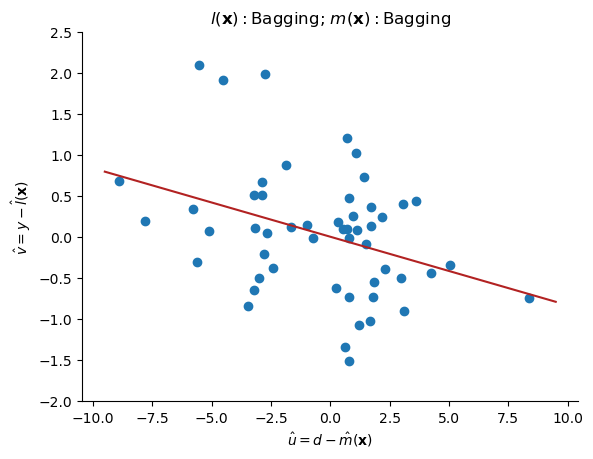

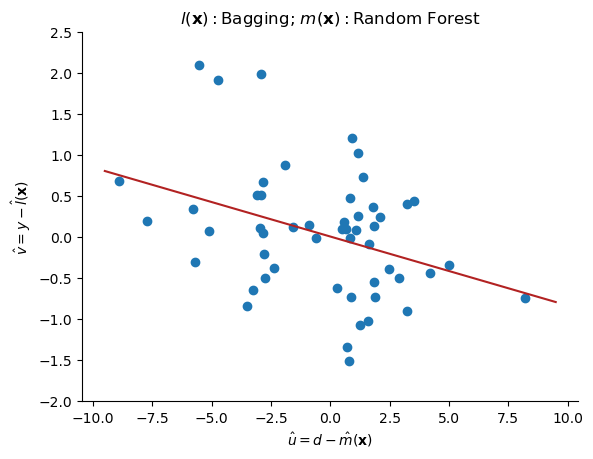

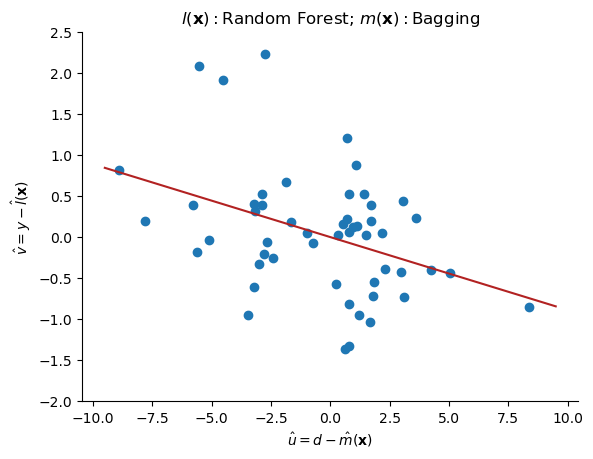

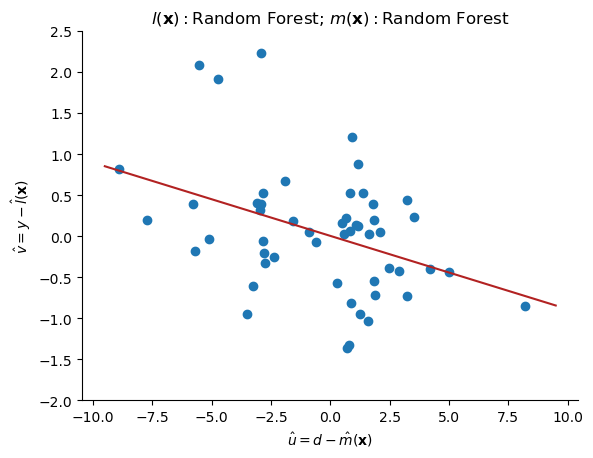

In [21]:
def plotCausalTrend(result, xrange, yrange, title):
    fig, ax = plt.subplots()
    
    ypred = xrange*result['alpha'] + result['intercept']
    
    _ = ax.scatter(x=result['res_d'], y=result['res_y'])
    _ = ax.plot(xrange, ypred, color='firebrick')
    _ = ax.set_ylim(yrange)
    _ = ax.spines['top'].set_visible(False)
    _ = ax.spines['right'].set_visible(False)
    _ = ax.set_ylabel(r'$\hat{v} = y - \hat{l}(\mathbf{x})$')
    _ = ax.set_xlabel(r'$\hat{u} = d - \hat{m}(\mathbf{x})$')
    _= ax.set_title(title)

#------------------------------------------------------

umin = min([resBgyBgd['res_d'].min(), resBgyRfd['res_d'].min(), resRfyBgd['res_d'].min(), resRfyRfd['res_d'].min()])
umax = max([resBgyBgd['res_d'].max(), resBgyRfd['res_d'].max(), resRfyBgd['res_d'].max(), resRfyRfd['res_d'].max()])
vmin = min([resBgyBgd['res_y'].min(), resBgyRfd['res_y'].min(), resRfyBgd['res_y'].min(), resRfyRfd['res_y'].min()])
vmax = max([resBgyBgd['res_y'].max(), resBgyRfd['res_y'].max(), resRfyBgd['res_y'].max(), resRfyRfd['res_y'].max()])
print("urange:" + str((umin,umax)))
print("vrange:" + str((vmin,vmax)))
urange = np.array([-9.5, 9.5])
vrange = np.array([-2.0, 2.5])

plotCausalTrend(resBgyBgd, urange, vrange, r'$l(\mathbf{x}): \text{Bagging; } m(\mathbf{x}): \text{Bagging}$')
plt.show()
plotCausalTrend(resBgyRfd, urange, vrange, r'$l(\mathbf{x}): \text{Bagging; } m(\mathbf{x}): \text{Random Forest}$')
plt.show()
plotCausalTrend(resRfyBgd, urange, vrange, r'$l(\mathbf{x}): \text{Random Forest; } m(\mathbf{x}): \text{Bagging}$')
plt.show()
plotCausalTrend(resRfyRfd, urange, vrange, r'$l(\mathbf{x}): \text{Random Forest; } m(\mathbf{x}): \text{Random Forest}$')
plt.show()


### Impiego della libreria DoubleML
In alternativa all'implementazione un po naïve di **dlmFit**, è possibile utilizzare la libreria DoubleML (https://docs.doubleml.org/stable/index.html): il listato che segue mostra l'uso della funzione **DoubleMLPLR** (https://docs.doubleml.org/stable/api/generated/doubleml.DoubleMLPLR.html#doubleml.DoubleMLPLR.fit) in relazione all'impiego di Random Forest sia per $l(\mathbf{x})$ che $d(\mathbf{x})$

In [22]:
import doubleml as dml

np.random.seed(rstate)

data = x.copy()
data['y'] = y
data['d'] = d
dml_data = dml.DoubleMLData(data, y_col='y', d_cols='d')

modely = RandomForestRegressor(n_estimators= 100, min_samples_leaf=5, max_features=10, n_jobs=-1, random_state=313)
modeld = RandomForestRegressor(n_estimators=1000, min_samples_leaf=3, max_features=12, n_jobs=-1, random_state=313)
dml_plr_obj = dml.DoubleMLPLR(dml_data, ml_l=modely, ml_m=modeld, n_folds=kfolds)
resDoubleML = dml_plr_obj.fit()
print(resDoubleML)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']
Instrument variable(s): None
No. Observations: 52

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_features=10, min_samples_leaf=5, n_jobs=-1,
                      random_state=313)
Learner ml_m: RandomForestRegressor(max_features=12, min_samples_leaf=3, n_estimators=1000,
                      n_jobs=-1, random_state=313)
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[0.80116171]]
Learner ml_m RMSE: [[3.05741461]]

------------------ Resampling        ------------------
No. folds: 4
No. repeated sample 

**Osservazione** I valori ottenuti, seppur in linea con quelli restituiti da dmlFit, differiscono da essi. L'ipotesi è che la causa di tali differenze sia imputabile a qualche variante implementativa, in particolare nella modalità con cui i dati vengono partizionati casualmente per il cross-fitting. A tale proposito si vedano i test Monte Carlo più avanti.

### Impiego delle variabili strumentali
Come ulteriore esperimento, si vuole sfruttare la libreria DoubleML per aggiungere al modello causale anche le variabili
strumentali proposte da Nunn: a tale scopo si è ricorsi alla funzione **DoubleMLPLIV**, come riportato nel listato seguente, a cui viene passato anche un modello ML per le variabili strumentali: con riferimento ai valori trovati attraverso la cross-validazione dei modelli per le variabili $z_i$ ($i=1 \dots 4$), il modello scelto è una Random Forest con parametri *n_estimators*=500, *max_features*=12, *min_sample_leaf*=3. 

Il razionale dietro alla scelta fatta è che, per le variabili strumentali $z_i$, *min_sample_leaf*=3 è il valore più ricorrente sia nel caso di Bagging che Random Forest; inoltre nelle Random Forest *max_features*=12 è, oltre ad essere anch’esso il valore più gettonato, prossimo a 13 (caso in cui si ha Bagging) ed infine è stato scelto il valore massimo di alberi *n_estimators*=500
perché per Bagging e Random Forest un incremento degli stimatori non crea overfitting.

In [23]:
dataIV = x.copy()
dataIV['y'] = y
dataIV['d'] = d
dataIV['z1'] = df.atlantic_distance_minimum
dataIV['z2'] = df.indian_distance_minimum
dataIV['z3'] = df.saharan_distance_minimum
dataIV['z4'] = df.red_sea_distance_minimum
dml_dataIV = dml.DoubleMLData(dataIV, y_col='y', d_cols='d', z_cols=['z1','z2','z3','z4'])

np.random.seed(rstate)
modely = RandomForestRegressor(n_estimators= 100, min_samples_leaf=5, max_features=10, n_jobs=-1, random_state=313)
modeld = RandomForestRegressor(n_estimators=1000, min_samples_leaf=3, max_features=12, n_jobs=-1, random_state=313)
modelz = RandomForestRegressor(n_estimators= 500, min_samples_leaf=3, max_features=12, n_jobs=-1, random_state=313)
dml_pliv_obj = dml.DoubleMLPLIV(dml_dataIV, ml_l=modely, ml_m=modelz, ml_r=modeld, n_folds=kfolds)

resDoubleML_IV = dml_pliv_obj.fit()
print(resDoubleML_IV)


================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: y
Treatment variable(s): ['d']
Covariates: ['colony1', 'colony2', 'colony3', 'colony4', 'colony5', 'colony6', 'colony7', 'abs_latitude', 'longitude', 'rain_min', 'humid_max', 'low_temp', 'ln_coastline_area']
Instrument variable(s): ['z1', 'z2', 'z3', 'z4']
No. Observations: 52

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(max_features=10, min_samples_leaf=5, n_jobs=-1,
                      random_state=313)
Learner ml_m: RandomForestRegressor(max_features=12, min_samples_leaf=3, n_estimators=500,
                      n_jobs=-1, random_state=313)
Learner ml_r: RandomForestRegressor(max_features=12, min_samples_leaf=3, n_estimators=1000,
                      n_jobs=-1, random_state=313)
Out-of-sample Performance:
Regress

**Osservazione** La stima trovata per $\alpha$ utilizzando anche le IV suggerisce un maggior impatto del trattamento, risultato in linea anche con quanto ricavato da Nunn introducendo nell'analisi anche le IV rispetto alla semplice regressione con OLS

### Esperimenti Monte Carlo
I risultati ottenuti finora sono relativi ad una qualche particolare partizione del dataset: rimescolando la partizione in maniera
casuale, le stime fornite cambiano; per cui con approccio Monte Carlo (MC) variando casualmente la partizione per $T=250$ volte, otteniamo le distribuzioni campionare di $\alpha$ sia per l'approccio Naive che attraverso DoubleML, senza e con IV.

**ATTENZIONE: il valore di $T$ è stato limitato da motivi di potenza computazionale. L'esecuzione del seguente blocco in Jupiter ha richiesto circa 2h.**

Per precauzione e semplicità riportiamo i grafici delle distribuzioni campionarie ottenute, indicando per ciascun caso valor medio $\bar{\alpha}$ e deviazione standard $\sigma_\alpha$: notiamo che le distribuzioni di $\alpha$ date da **dlmFit** e da **DoubleMLPLR** sono molto simili, mostrando in particolare valor medio $\bar{\alpha}$ e deviazione standard $\sigma_\alpha$ quasi uguali: $\bar{\alpha} \approx -0.087$ e $\sigma_\alpha \approx 0.015$ in entrambi i casi. 

Viceversa la distribuzione campionaria di $\alpha$ trovata per **DoubleMLPLIV** ha valor medio $\bar{\alpha} = -0.2590$ e deviazione standard $\sigma_\alpha = 0.0879$: la distribuzione ottenuta è piuttosto differente rispetto a quelle prodotte da **dlmFit** e da **DoubleMLPLR**, mostrando una certa asimmetria e maggiore dispersione; in ogni caso il valor medio per $\alpha$ è sensibilmente maggiore rispetto a quello ottenuto senza variabili strumentali (ossia $\bar{\alpha} \approx -0.087$).


**Test MC su dlmFit:**  $\bar{\alpha}=-0.0874$, $\sigma_\alpha=0.0145$
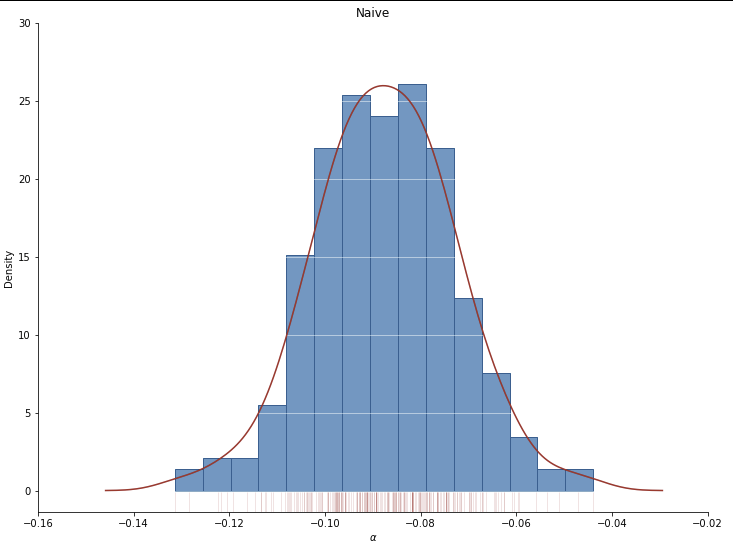

**Test MC su DoubleMLPLR:**  $\bar{\alpha} = -0.0873$, $\sigma_\alpha=0.0146$
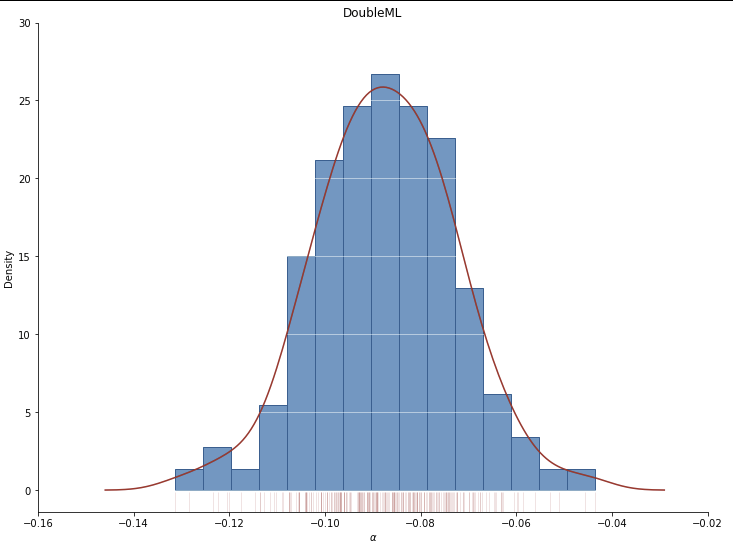

**Test MC su DoubleMLPLIV:**  $\bar{\alpha}=-0.2590$, $\sigma_\alpha=0.0879$
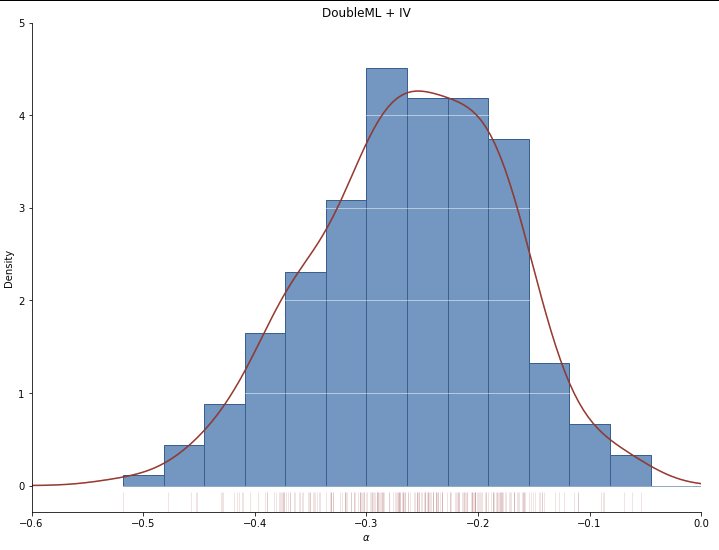

Checked Windows O.S.: importing multiprocessing.dummy
Monte Carlo per dmlFit
250: 0:06:42.043507
(-0.08744983884243018, 0.014524630258841703)


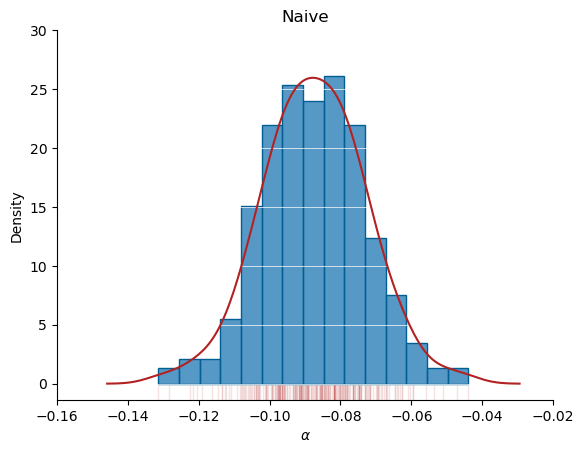


Monte Carlo per DoubleMLPLR
250: 0:29:30.718939
(-0.08732835545240832, 0.014630450529025564)


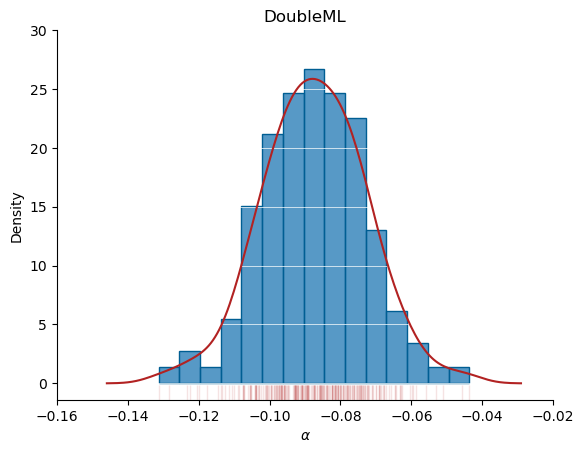


Monte Carlo per DoubleMLPLIV
250: 1:23:33.997454
(-0.25897267653998973, 0.08787682514170458)


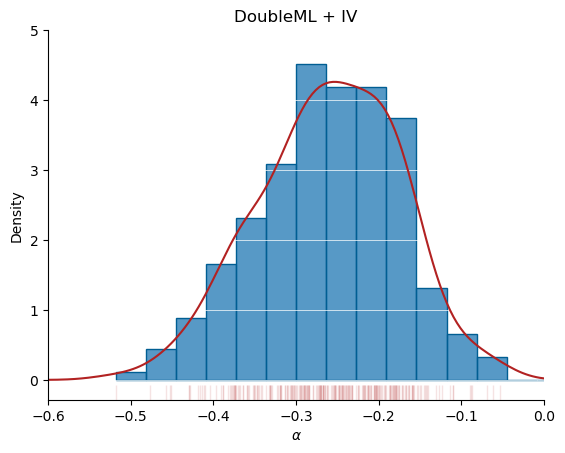

In [24]:
from multiprocessing import Pool
import platform
if 'windows' in str.lower(platform.system()):
    from multiprocessing.dummy import Pool
    print('Checked Windows O.S.: importing multiprocessing.dummy')
else:
    print('Not Windows O.S.: importing multiprocessing')
    


def calcDMLTreatmentImpactRfyRfd(dml_data, nfolds,rstate,t=1, extendedOutput=False):
    modely = RandomForestRegressor(n_estimators= 100, 
                                   min_samples_leaf=5, 
                                   max_features=10, 
                                   random_state=313,
                                   n_jobs=-1
                                   )
    modeld = RandomForestRegressor(n_estimators=1000, 
                                   min_samples_leaf=3, 
                                   max_features=12, 
                                   random_state=313, 
                                   n_jobs=-1
                                   )
    np.random.seed(rstate+100*t)
    dml_plr_obj = dml.DoubleMLPLR(dml_data, ml_l=modely, ml_m=modeld, n_folds=nfolds)
    resDoubleML = dml_plr_obj.fit()
    if (extendedOutput):
        return resDoubleML
    return resDoubleML.coef[0]


def calcDMLIvTreatmentImpactRfyRfd(dml_dataIV, nfolds,rstate,t=1, extendedOutput=False):
    modely = RandomForestRegressor(n_estimators= 100, 
                                   min_samples_leaf=5, 
                                   max_features=10, 
                                   random_state=313,
                                   n_jobs=-1
                                   )
    modeld = RandomForestRegressor(n_estimators=1000, 
                                   min_samples_leaf=3, 
                                   max_features=12, 
                                   random_state=313, 
                                   n_jobs=-1
                                   )
    modelz = RandomForestRegressor(n_estimators= 500, 
                                   min_samples_leaf=3, 
                                   max_features=12, 
                                   random_state=313,
                                   n_jobs=-1, 
                                   )
    
    np.random.seed(rstate+100*t)
    dml_pliv_obj = dml.DoubleMLPLIV(dml_dataIV, ml_l=modely, ml_m=modelz, ml_r=modeld, n_folds=nfolds)
    resDoubleML_IV = dml_pliv_obj.fit()

    if (extendedOutput):
        return resDoubleML_IV
    return resDoubleML_IV.coef[0]

def plotAlphaHist(alphas, xrange, ytop, title):
    fig, ax = plt.subplots()
    _ = sns.rugplot(x=alphas, ax=ax, color='firebrick', alpha=0, height=0)
    _ = sns.rugplot(x=alphas, ax=ax, color='firebrick', alpha=0.125, height=0.04, expand_margins=False)
    _ = sns.histplot(alphas, ax=ax, stat='density', edgecolor='#005e93')
    _ = sns.kdeplot(alphas, ax=ax, color='firebrick')
    _ = ax.set_xlim(xrange)
    _ = ax.set_ylim(top=ytop)
    _ = ax.grid(axis='y', color='white', linewidth=0.5)
    _ = ax.spines['top'].set_visible(False)
    _ = ax.spines['right'].set_visible(False)
    _ = ax.set_xlabel(r'$\alpha$');
    _= ax.set_title(title)


#-----------------------------------------
np.random.seed(rstate)
T = 250

import datetime
start = datetime.datetime.now()
alphasNaive = [];
chunkList = [(x,d,y, kfolds,rstate, t+1) for t in range(T)]
with Pool(processes=None) as pool:
    alphasNaive = pool.starmap(calcNaiveDlmTreatmentImpactRfyRfd, chunkList)
dt = datetime.datetime.now() - start
print("Monte Carlo per dmlFit")
print(str(T) + ': ' + str(dt))
print((np.mean(alphasNaive), np.std(alphasNaive)))

plotAlphaHist(alphasNaive, xrange=(-0.16,-0.02),ytop=30, title='Naive')
plt.show()

#----------
np.random.seed(rstate)

start = datetime.datetime.now()
alphasDML = [];
for t in range(T): # DoubleMLPLR non consente risultati riproducibili con la parallelizzazione offerta da Pool
    alphasDML.append(calcDMLTreatmentImpactRfyRfd(dml_data, kfolds,rstate,t+1))
dt = datetime.datetime.now() - start
print("\nMonte Carlo per DoubleMLPLR")
print(str(T) + ': ' + str(dt))
print((np.mean(alphasDML), np.std(alphasDML)))

plotAlphaHist(alphasDML, xrange=(-0.16,-0.02),ytop=30, title='DoubleML')
plt.show()

#----------
np.random.seed(rstate)

start = datetime.datetime.now()
alphasDMLIv = [];
for t in range(T): # DoubleMLPLIV non consente risultati riproducibili con la parallelizzazione offerta da Pool
    alphasDMLIv.append(calcDMLIvTreatmentImpactRfyRfd(dml_dataIV, kfolds,rstate,t+1))
dt = datetime.datetime.now() - start
print("\nMonte Carlo per DoubleMLPLIV")
print(str(T) + ': ' + str(dt))
print((np.mean(alphasDMLIv), np.std(alphasDMLIv)))

plotAlphaHist(alphasDMLIv, xrange=(-0.6,0.0),ytop=5, title='DoubleML + IV')
plt.show()


# Conclusioni
L’elaborato si è basato sul lavoro svolto da Nunn che ha analizzato attraverso delle variabili strumentali l’impatto a lungo termine che la tratta degli schiavi (il trattamento) ha avuto sull’economia odierna degli Stati africani (risposta caratterizzata dal PIL degli Stati); le variabili strumentali proposte da Nunn sono costituite dalla distanza di ciascun Paese rispetto alle destinazioni principali nella domanda di schiavi per le quattro tratte subite dal continente africano.

Riprendendo il dataset annesso all’articolo, sono stati prima replicati alcuni risultati sull'impatto del trattamento mostrati nel paper sia per quanto riguarda le stime OLS (senza IV) che quelle ottenute ricavate tramite Two-Stage LS con le IV.

Successivamente è stata condotta l’analisi causale con approccio Double ML, applicata ad una delle tante combinazioni di controlli valutate da Nunn (passato coloniale e caratteristiche geo-climatiche dei vari Paesi): dal confronto tra i valori trovati da Nunn con quelli ottenuti tramite Double ML concludiamo che le stime ricavate attraverso l’impiego di tecniche Machine Learning sono in
linea con quelle ottenute in maniera classica, come si evince dalla seguente tabella riassuntiva sulle stime di $\alpha$ (per dmlFit e la libreria DoubleML sono stati riportati i valori medi degli esperimenti Monte Carlo).

|       | Nunn    | dlmFit  | DoubleML |
|---    |---      |---      |---       |
| No IV | -0.0762 | -0.0874 | -0.0873  |
| IV    | -0.2857 |         | -0.2590  |

Il presente lavoro potrebbe essere esteso impiegando un maggior numero di controlli (includendo anche la produzione mineraria e tutte le aree geografiche, non solo la variabile per il Nord Africa), e aumentando il numero $T$ degli esperimenti Monte Carlo allo scopo di ottenere risultati più accurati: le restrizioni nell’elaborato sono dipese dai tempi di calcolo per la limitata potenza computazionale disponibile.

# Bibliografia completa
Seppur non citate tutte esplicitamente nel flusso del notebook, nella preparazione di questo elaborato si è fatto ricorso alle seguenti pubblicazioni
- A. Ahrens, C.B. Hansen, M.E. Schaffer, and T. Wiemann. *"ddml: Double/debiased machine learning in stata"*. The Stata Journal, 24(1):3–
45, 2024. https://journals.sagepub.com/doi/epub/10.1177/1536867X241233641
- P. Bach, V. Chernozhukov, M.S. Kurz, and M. Spindler. *"DoubleML – An object-oriented implementation of double machine learning
in Python"*. Journal of Machine Learning Research, 23(53):1–6, 2022. https://www.jmlr.org/papers/volume23/21-0862/21-0862.pdf
- P. Bach, O. Schacht, V. Chernozhukov, S. Klaassen, and M. Spindler. *"Hyperparameter tuning for causal inference with double
machine learning: A simulation study"*. In Francesco Locatello and Vanessa Didelez, editors, Proceedings of the Third Conference on Causal Learning and Reasoning, volume 236 of Proceedings of Machine Learning Research, pages 1065–1117. PMLR, 01–03 April 2024. https://proceedings.mlr.press/v236/bach24a/bach24a.pdf
- V. Chernozhukov, D. Chetverikov, M. Demirer, E. Duflo, C. Hansen, W. Newey, and J. Robins. *"Double/debiased machine learning for treatment and structural parameters"*. The Econometrics Journal, 21(1):C1–C68, 01 2018. https://academic.oup.com/ectj/article/21/1/C1/5056401
- V. Chernozhukov, C. Hansen, N. Kallus, M. Spindler, and V. Syrgkanis. *"Applied Causal Inference Powered by ML and AI"*. 2024. CausalML-book.org; arXiv:2403.02467. https://causalml-book.org/
- G. James, D. Witten, T. Hastie, R. Tibshirani, and J. Taylor. *"An Introduction to Statistical Learning with Applications in
Python"*. Springer Texts in Statistics. Springer, 2023. https://www.statlearning.com/
- Nathan Nunn. *"The Long-term Effects of Africa’s Slave Trades"*. The Quarterly Journal of Economics, 123(1):139–176, 2008. https://nathannunn.sites.olt.ubc.ca/files/2022/07/nathannunn-the-long-term-effect.pdf